In [1]:
!python -m pip install git+https://github.com/VissaMoutafis/opacus.git@35b88529db696444a87d166ca429232d46495658

  Cloning https://github.com/VissaMoutafis/opacus.git (to revision 35b88529db696444a87d166ca429232d46495658) to /tmp/pip-req-build-q1ilx3p3
  Running command git clone -q https://github.com/VissaMoutafis/opacus.git /tmp/pip-req-build-q1ilx3p3
  Running command git rev-parse -q --verify 'sha^35b88529db696444a87d166ca429232d46495658'
  Running command git fetch -q https://github.com/VissaMoutafis/opacus.git 35b88529db696444a87d166ca429232d46495658
  Created wheel for opacus: filename=opacus-1.1.1-py3-none-any.whl size=176082 sha256=32b33261db386092600667e73a5189b9fdb145d1247d64739e4193c523c4c76a
  Stored in directory: /root/.cache/pip/wheels/31/22/7c/1df2d3aaa41407ef52bac1d0f1845f0a5644b409a4b458ac74
Successfully built opacus


In [4]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=9ead626150a5426b1fb477d344ad76007c9ae73c85f821a9956d978bb1d34141
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets
from tqdm import tqdm

from mia_v2.torch2tf import *
from mia_v2.attack_model import *
from mia_v2.label_only import *
from mia_v2.shadow_models import *
from mia_v2.utilities import *
from mia_v2.wrappers import ConfidenceVectorAttack, LabelOnlyAttack

from opacus import PrivacyEngine

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
ATTACKER_DATASET_SIZE = 10000
SHADOW_MODELS = 10
SHADOW_DATASET_SIZE = 2500
TARGET_DATASET_SIZE = 2500

In [7]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [8]:
train_labels = train_labels.reshape(-1).astype(np.int64)
test_labels = test_labels.reshape(-1).astype(np.int64)
train_images = (train_images / 255).reshape((-1, 3, 32, 32))
test_images = (test_images / 255).reshape((-1, 3, 32, 32))

attacker_images = np.concatenate((test_images, train_images[TARGET_DATASET_SIZE:]))[:ATTACKER_DATASET_SIZE]
attacker_labels = np.concatenate((test_labels, train_labels[TARGET_DATASET_SIZE:]))[:ATTACKER_DATASET_SIZE]
train_images = train_images[:TARGET_DATASET_SIZE]
train_labels = train_labels[:TARGET_DATASET_SIZE]
train_images, test_images, train_labels, test_labels = train_test_split(train_images, train_labels, test_size=0.3, shuffle=True, random_state=0)


In [9]:
class TargetModel(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 32, 3)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(32, 64, 3)
      self.fc1 = nn.Linear(2304, 256)
      self.fc2 = nn.Linear(256, 10)
      self.double()
      self.to(device)


    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [10]:
target_model = TargetModel()

In [11]:
criterion = nn.CrossEntropyLoss
optimizer = {'builder':optim.Adam, 'args':{'lr':0.001}}


In [12]:
from math import log
privacy= {
    'engine':PrivacyEngine(),
    'args':{
        'epochs': 100,
        'target_epsilon':100*log(100),
        'target_delta':1/(TARGET_DATASET_SIZE),
        'max_grad_norm':1
        }
}

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:131: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


In [13]:
igniter = TfIgniter((3, 32, 32), (32, 32, 3), target_model, device)

igniter.fit(train_images, 
            train_labels, 
            validation_data=(test_images, test_labels), 
            verbose=True, 
            privacy=privacy, 
            epochs=100, 
            batch_size =64, 
            es=CustomEarlyStopping(patience=10, min_delta=2e-5), optimizer=optimizer, criterion=criterion)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/opacus/accountants/analysis/rdp.py:333: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  f"Optimal order is the {extreme} alpha. Please consider expanding the range of alphas to get a tighter privacy bound."


Using sigma=0.2862274646759033 and C=1


{'privacy': {'epsilon': [33.037207877842576,
   42.335147003182584,
   51.63308612852259,
   59.74952882929031,
   65.58269533634198,
   71.41586184339366,
   77.24902835044531,
   83.08219485749699,
   88.91536136454866,
   94.74852787160032,
   100.58169437865199,
   106.41486088570366,
   112.24802739275533,
   118.08119389980699,
   123.91436040685866,
   129.74752691391035,
   135.580693420962,
   141.41385992801366,
   147.24702643506532,
   152.01372409695077,
   155.8699371499122,
   159.7261502028737,
   163.5823632558352,
   167.43857630879666,
   171.29478936175812,
   175.1510024147196,
   179.00721546768108,
   182.86342852064254,
   186.71964157360404,
   190.5758546265655,
   194.43206767952697,
   198.28828073248846,
   202.14449378544992,
   206.0007068384114,
   209.85691989137288,
   213.71313294433435,
   217.56934599729584,
   221.4255590502573,
   225.28177210321877,
   229.13798515618026,
   232.99419820914173,
   236.8504112621032,
   240.7066243150647,
   244.5

In [14]:
def f_shadow():
  return TfIgniter((3, 32, 32), (32, 32, 3), TargetModel(), device)

In [15]:
attack = ConfidenceVectorAttack(igniter, (train_images.reshape(-1, 32, 32, 3), train_labels), 
                                  (attacker_images.reshape(-1, 32, 32, 3), attacker_labels), shadow_creator=f_shadow, attack_model_creator=cifar_10_f_attack_builder,
                                n_shadows=SHADOW_MODELS, D_shadow_size=SHADOW_DATASET_SIZE, verbose=True)
es = CustomEarlyStopping(patience=20, min_delta=2e-4)
attack.perform_attack(shadow={'epochs':100, 'batch_size':64, 'es':es, 'optimizer':optimizer, 'criterion':criterion})

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Preparing shadow batch of size 1650


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Preparing shadow batch of size 1650
Done!
Epoch 1/50
181/181 [==============================] - 4s 5ms/step - loss: 0.6949 - accuracy: 0.5160 - val_loss: 0.6932 - val_accuracy: 0.5251
Epoch 2/50
181/181 [==============================] - 1s 5ms/step - loss: 0.6904 - accuracy: 0.5366 - val_loss: 0.6908 - val_accuracy: 0.5196
Epoch 3/50
181/181 [==============================] - 1s 4ms/step - loss: 0.6885 - accuracy: 0.5455 - val_loss: 0.6888 - val_accuracy: 0.5485
Epoch 4/50
181/181 [==============================] - 1s 4ms/step - loss: 0.6873 - accuracy: 0.5446 - val_loss: 0.6875 - val_accuracy: 0.5386
Epoch 5/50
181/181 [============================

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


class-1 acc: 0.5273224115371704
class-2 acc: 0.5150684714317322
class-3 acc: 0.4857954680919647
class-4 acc: 0.5178571343421936
class-5 acc: 0.5197740197181702
class-6 acc: 0.5552147030830383
class-7 acc: 0.5524079203605652
class-8 acc: 0.5071225166320801
class-9 acc: 0.5201149582862854
class-10 acc: 0.515759289264679
              precision    recall  f1-score   support

         Out       0.51      0.75      0.61      1750
          In       0.54      0.29      0.38      1750

    accuracy                           0.52      3500
   macro avg       0.53      0.52      0.50      3500
weighted avg       0.53      0.52      0.50      3500

AUC: 0.5312762448979592


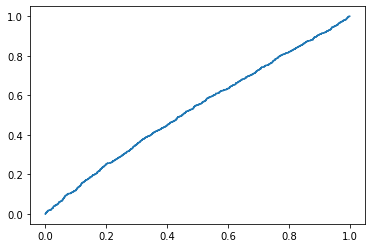

In [16]:
attack.target_model = igniter
_score = attack.evaluate_attack()